In [1]:
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np

import virl
import utils

### Tabular Q-learning

This script trains an agent using traditional Q-learning. This involves approximating a $Q(s,a)$ table that stores an estimation of discounted future reward for taking action $a$ in state $s$. The table will contain an entry for every state action pair. 

#### Discretization

Because this is a continuous task, we must first discretize the state space into bins, however it is not immediately obvious how many bins to have and what scale should be used. Too many states and the agent will not be able to learn anything as the state space is too big, too few and it will not have enough distinguishing power to make sensible choices. It must also be considered whether to use a linear or logarithmic scale to allocate to different bins. As a result discretization method essentially becomes a hyperparameter of the training process. 

The general approach here is to structure the Q table as a 5 dimensional numpy array, one dimension for each of the 4 state variables and one for the action. This means an index such as `Q[1,2,3,4,0]` would represent the estimated Q-value for taking action 0 when s[0] falls into bin 1, s[1] falls into bin 2, s[2] falls into bin 3 and s[3] falls into bin 4.

Discretization will be handled by the `discretize()` function which will take the current continuous state, total population (in this case `np.sum(s)`) and the number of bins, and return a discretete state space.

#### Learning Q values

The key equation for Q learning is the update rule, given as follows $eqn(1)$:

$
Q(s,a) = Q(s,a) + \alpha (R(s) + \gamma \max_{a'}Q(s',a')-Q(s,a) )
$

Where $Q(s,a)$ is the Q value for the current state action pair $a$, $s$. $\alpha$ is the learning rate. $R(s)$ is the reward for state $s$. $\gamma$ is the discount factor. $Q(s',a')$ is the Q value for the new state $s'$ after taking action $a$ in state $s$, and the best known action $a'$ in that state $s'$.

The psuedocode for learning the Q values is as follows:

```
initialize Q table as 5d numpy array of zeros
initialize epsilon
for each episode:
    reset state to initial state
    while state is not terminal:
        discretize state
        
        action is index of max value of Q[s[0], s[1], s[2], s[3], :]
        if rand < epsilon:
            make action random
        
        store the value of Q[s[0], s[1], s[2], s[3], action]
        
        take action and get new state, and reward
        discretize new state
        
        best action is index of max value of Q[new_s[0], new_s[1], new_s[2], new_s[3], :]
        store Q[new_s[0], new_s[1], new_s[2], new_s[3], best]
        
        calculate new value for Q[s[0], s[1], s[2], s[3], action] according to eqn(1) above
    end while
    reduce epsilon size
end for

```

In [2]:
bins = 20
def discretize(s, population=600000000, bins=bins):
    bins = np.geomspace(1, population, num=bins)
    return np.digitize(s, bins=bins)

In [3]:
env = virl.Epidemic(stochastic=False, noisy=False, problem_id=0)

learning_rate = 0.1
discount_factor = 0.95

episodes = 5000
avg_episode_rewards = []
Q = np.zeros((bins,bins,bins,bins, env.action_space.n))
epsilon = 1.0
for i in range(episodes):
    states = []
    rewards = []
    done = False

    s = env.reset()
    states.append(s)
    while not done:
        discretized_s = discretize(s)
        action = np.argmax(Q[(*discretized_s, None)])
        if np.random.random() < epsilon:
            action = np.random.choice(env.action_space.n)
        
        q_sa = Q[(*discretized_s, action)]
        
        s, r, done, _ = env.step(action=action)
        
        discretized_new_s = discretize(s)
        s_next_q_values = np.argmax(Q[(*discretized_new_s, None)])
        best_s_next_q_value = Q[(*discretized_new_s, s_next_q_values)]
        
        new_q_sa = q_sa + learning_rate + (r + discount_factor * best_s_next_q_value - q_sa)
        
        Q[(*discretized_s, action)] = new_q_sa
        
        states.append(s)
        rewards.append(r)
    if epsilon > 0.001:
        epsilon*= 0.995
    if i % 50 == 0:
        print(i, "avg", sum(rewards) / len(rewards), "eps", epsilon, "Q", Q.sum())
    avg_episode_rewards.append(sum(rewards) / len(rewards))

0 avg -0.027671237831629572 eps 0.995 Q 4.403696430843463
50 avg -0.018393832456738778 eps 0.7744209942832988 Q 438.3554452629358
100 avg -0.028166049602825073 eps 0.6027415843082742 Q 721.6916704939877
150 avg -0.02475492692539028 eps 0.46912134373457726 Q 898.8851771705936
200 avg -0.02307430737080304 eps 0.36512303261753626 Q 968.6226092145198
250 avg -0.02392022049739519 eps 0.28417984116121187 Q 1013.8862361003733
300 avg -0.01854220761335195 eps 0.2211807388415433 Q 1030.835647282809
350 avg -0.017942408252781063 eps 0.17214774642209296 Q 1056.1829521122922
400 avg -0.017522140073203633 eps 0.13398475271138335 Q 1079.432932822996
450 avg -0.019705829230475775 eps 0.1042820154910064 Q 1099.738424814925
500 avg -0.027278449225789106 eps 0.0811640021330769 Q 1104.1371716459066
550 avg -0.018780174602602125 eps 0.06317096204211972 Q 1109.1404337264275
600 avg -0.018013074535394948 eps 0.04916675299948831 Q 1110.482946046692
650 avg -0.01956717773895755 eps 0.03826710124979409 Q 1112.

In [4]:
def policy(state):
    discretized_s = discretize(state)
    action = np.argmax(Q[(*discretized_s, None)])
    prob =  np.zeros(4)
    prob[action] = 1
    return prob

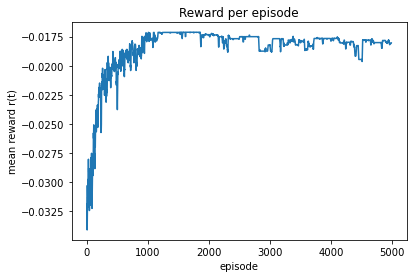

In [5]:
utils.plot_avg_reward(avg_episode_rewards, smoothing_window=9)

0 [3, 2, 3, 2, 3, 2, 2, 1, 1, 0, 3, 1, 3, 1, 3, 1, 0, 1, 0, 3, 3, 2, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3]
total reward -0.9405349652998889
1 [3, 2, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
total reward -0.33496700853339684
2 [3, 2, 0, 0, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 0, 3, 3, 3, 3, 3, 1, 3, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2]
total reward -0.5538355218342006
3 [3, 2, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
total reward -0.6952912324597476
4 [3, 2, 0, 1, 3, 3, 3, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 1, 3, 0, 1, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1]
total reward -0.831126615337159
5 [3, 0, 1, 2, 2, 2, 1, 1, 0, 1, 3, 1, 3

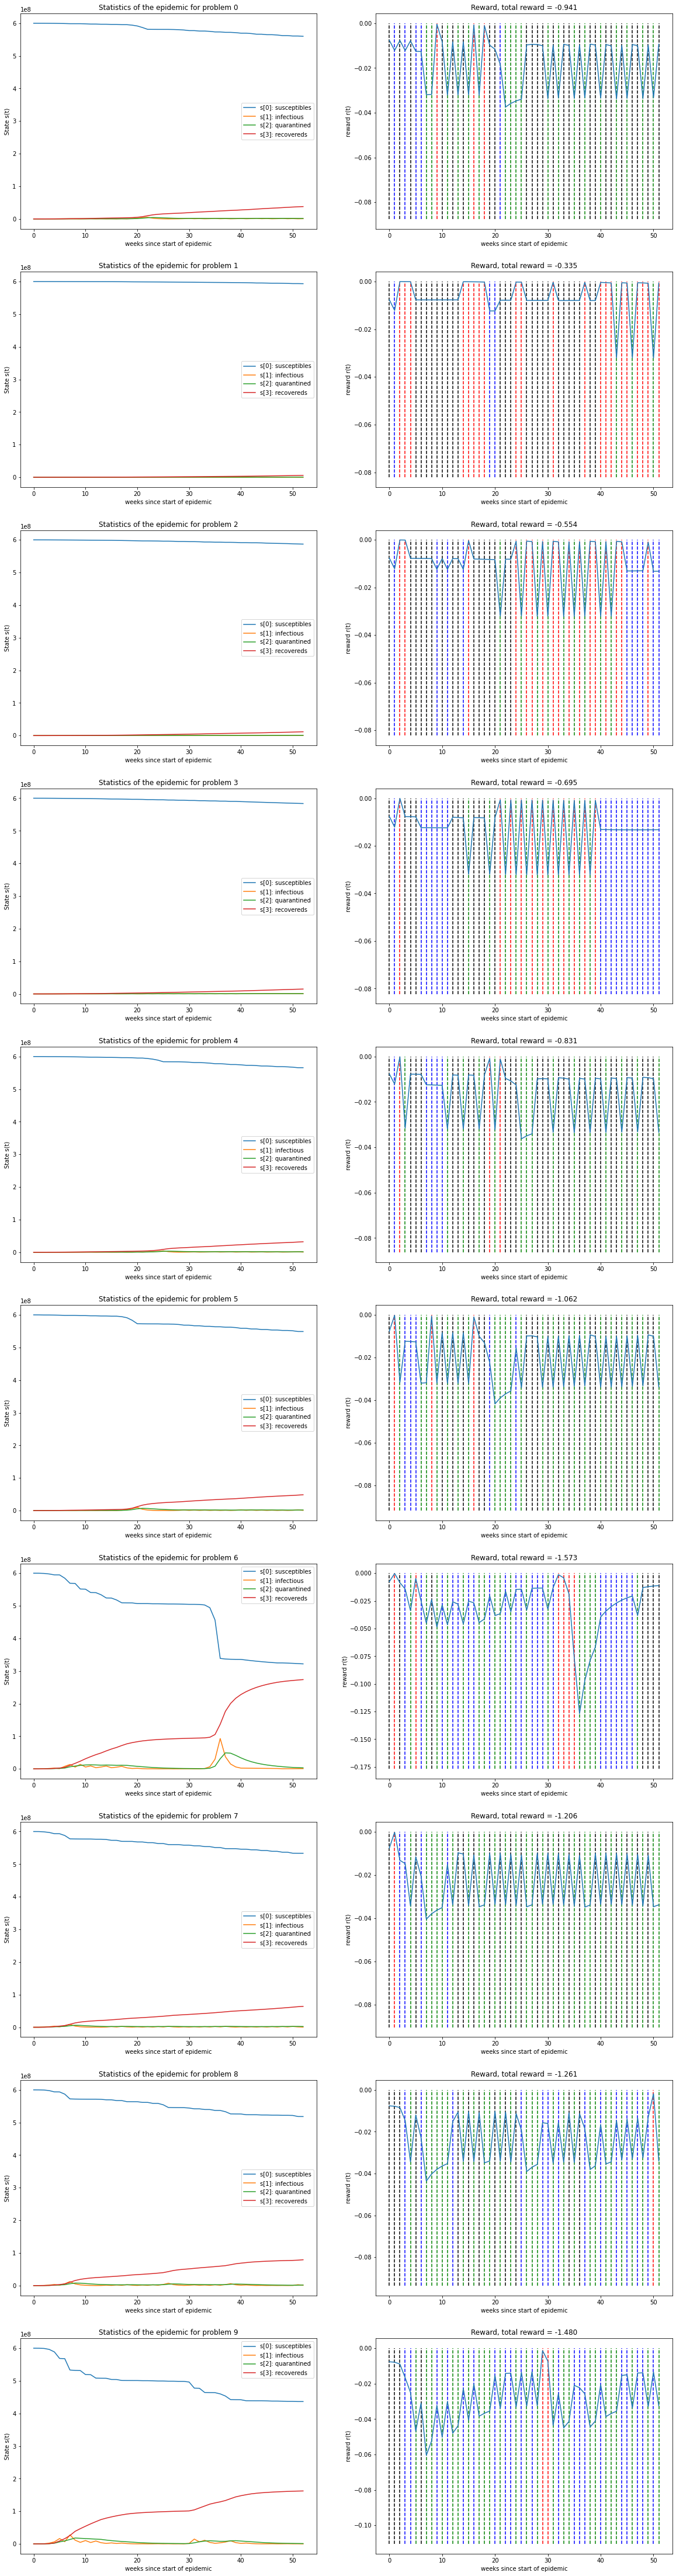

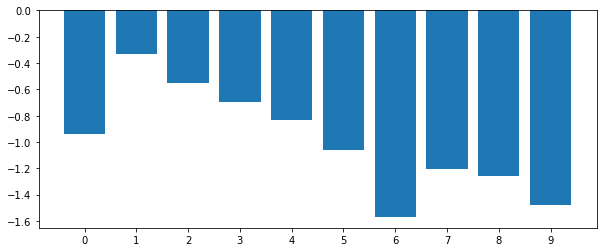

In [6]:
utils.evaluate(policy, full_eval=True)

0 [3, 2, 3, 2, 3, 2, 2, 1, 1, 0, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 2, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3]
total reward -0.9301497968702601
1 [3, 2, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0]
total reward -0.3231508535545021
2 [3, 2, 0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 2]
total reward -0.5397582279567115
3 [3, 2, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 3, 3, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
total reward -0.700838056180923
4 [3, 2, 0, 1, 3, 3, 3, 2, 2, 2, 1, 3, 3, 3, 1, 3, 3, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1]
total reward -0.8391285671440394
5 [3, 0, 1, 2, 2, 2, 2, 1, 3, 1, 3, 1, 0,

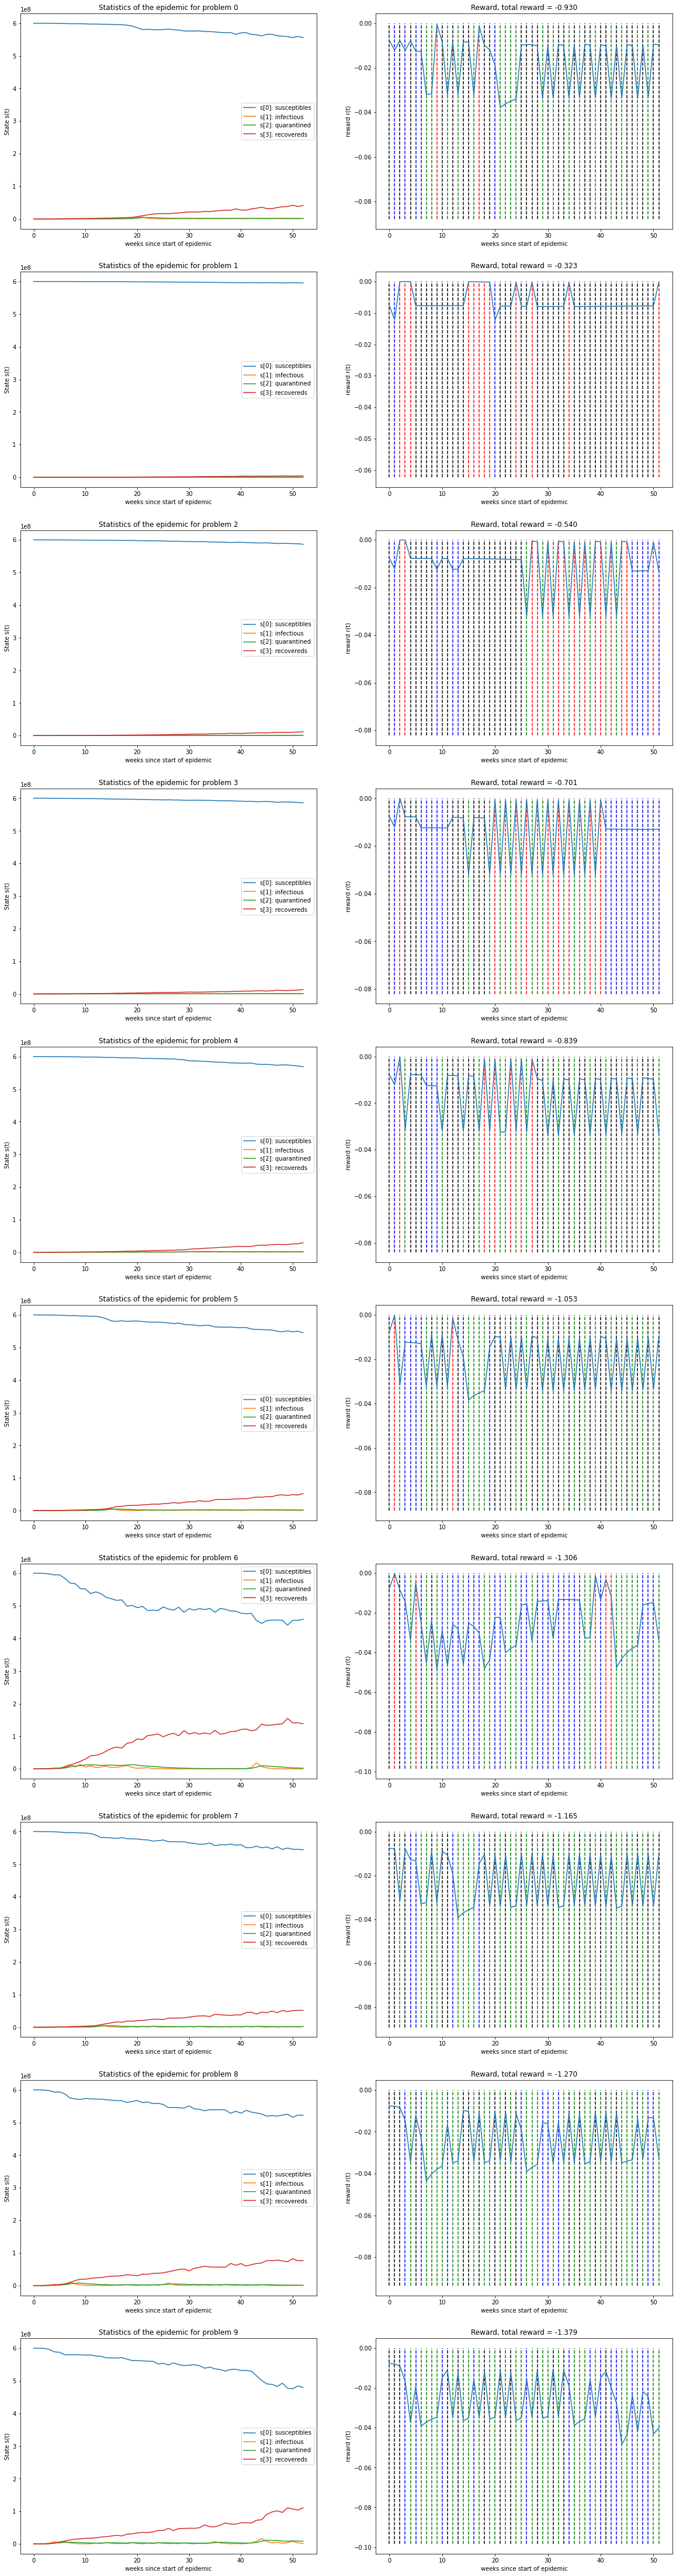

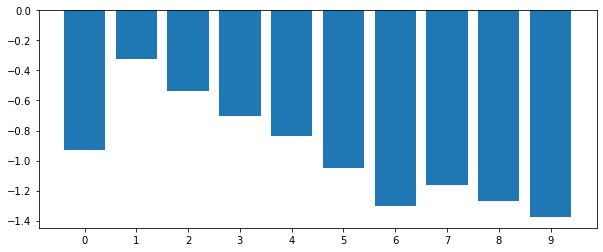

In [7]:
utils.evaluate(policy, full_eval=True, noisy=True)

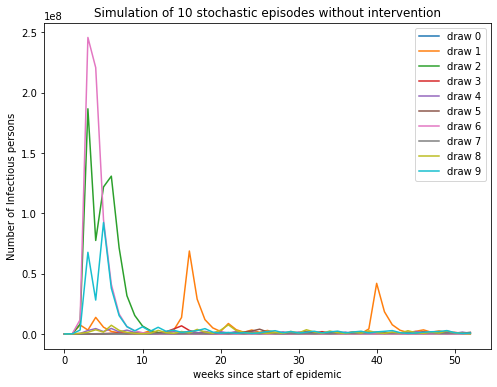

In [9]:
utils.evaluate_stochastic(policy)